In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.datasets import cifar10
import cv2

2025-01-11 01:00:26.796553: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 01:00:26.797282: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-11 01:00:26.801059: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-11 01:00:26.811262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736568026.827622  351455 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736568026.83

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
values, count = np.unique(y_train, return_counts=True)

In [3]:
def properties(data):
    print(f"The dataset has {data.shape[0]} images.")
    values, count = np.unique(data, return_counts = True)
    for i in zip(values, count):
        print(f"Value {i[0]} has {i[1]} samples")

In [4]:
print(f"labels and values for train data :")
print(f"{properties(y_train)}")

labels and values for train data :
The dataset has 50000 images.
Value 0 has 5000 samples
Value 1 has 5000 samples
Value 2 has 5000 samples
Value 3 has 5000 samples
Value 4 has 5000 samples
Value 5 has 5000 samples
Value 6 has 5000 samples
Value 7 has 5000 samples
Value 8 has 5000 samples
Value 9 has 5000 samples
None


In [5]:
print(f"labels and values for test data :")
print(f"{properties(y_test)}")

labels and values for test data :
The dataset has 10000 images.
Value 0 has 1000 samples
Value 1 has 1000 samples
Value 2 has 1000 samples
Value 3 has 1000 samples
Value 4 has 1000 samples
Value 5 has 1000 samples
Value 6 has 1000 samples
Value 7 has 1000 samples
Value 8 has 1000 samples
Value 9 has 1000 samples
None


In [6]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
y_train = y_train.reshape(-1,)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_test = y_test.reshape(-1,)

### Applying in the raw data.

In [9]:
%%time
from sklearn.linear_model import LogisticRegression

m1 = LogisticRegression(
    multi_class = "multinomial",
    solver = "lbfgs",
    max_iter = 500)

m1.fit(X_train_flat, y_train)

/home/arthur/Desktop/ML_topics/IRP/final_work/TP-final-IRDP/IRP_tp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: user 47min 49s, sys: 14.5 s, total: 48min 4s
Wall time: 7min 6s


/home/arthur/Desktop/ML_topics/IRP/final_work/TP-final-IRDP/IRP_tp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500, multi_class='multinomial')

In [10]:
y_pred1 = m1.predict(X_test_flat)

In [11]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred1)
print(f"The accuracy of the model {m1} is {acc}")

The accuracy of the model LogisticRegression(max_iter=500, multi_class='multinomial') is 0.3913


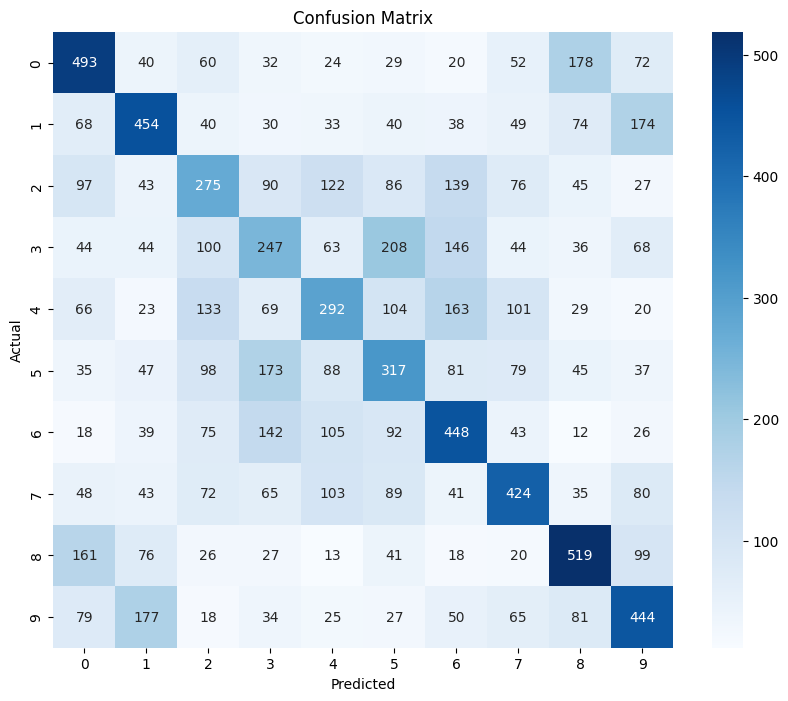

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm1 = confusion_matrix(y_test, y_pred1)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm1, annot = True, fmt = "d", cmap = "Blues", xticklabels = np.arange(10), yticklabels = np.arange(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Applying PCA to reduce the complexity.

In [13]:
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA

In [14]:
def compute_general_components(images):
    """
    Compute the components to apply the TSNE
    """
    std_ = np.zeros(images.shape[0])
    mean_ = np.zeros(images.shape[0])
    skew_ = np.zeros(images.shape[0])
    kurto_ = np.zeros(images.shape[0])
    for count, img in enumerate(images):
        std_[count] = np.std(img)
        mean_[count] = np.mean(img)
        skew_[count] = skew(img.flatten())
        kurto_[count] = kurtosis(img.flatten())

    return std_.reshape(-1, 1), mean_.reshape(-1, 1), skew_.reshape(-1, 1), kurto_.reshape(-1, 1)

In [15]:
def training_LR_PCA(X_train, y_train, epoch):
    model = LogisticRegression(
                            multi_class = "multinomial",
                            solver = "lbfgs",
                            max_iter = epoch)
    std_train, mean_train, skew_train, kurto_train = compute_general_components(X_train) # Taking the informations.
    arr_training = np.concatenate((std_train, mean_train, skew_train, kurto_train), axis = 1)
    #pca = PCA(n_components = 2)
    #x_pca = pca.fit_transform(arr_training)
    #model.fit(x_pca, y_train)
    model.fit(arr_training, y_train)
    
    return model

In [16]:
%%time

m2 = training_LR_PCA(X_train = X_train, y_train = y_train, epoch = 10)

/home/arthur/Desktop/ML_topics/IRP/final_work/TP-final-IRDP/IRP_tp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: user 1min 6s, sys: 28.4 ms, total: 1min 6s
Wall time: 1min 3s


/home/arthur/Desktop/ML_topics/IRP/final_work/TP-final-IRDP/IRP_tp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
def testing_LR_PCA(model, X_test):

    std_test, mean_test, skew_test, kurto_test = compute_general_components(X_test) # Taking the informations.
    arr_testing = np.concatenate((std_test, mean_test, skew_test, kurto_test), axis = 1)
    #pca = PCA(n_components = 2)
    #x_pca = pca.fit_transform(arr_testing)

    #return model.predict(x_pca)
    return model.predict(arr_testing)

In [18]:
y_pred2 = testing_LR_PCA(m2, X_test)

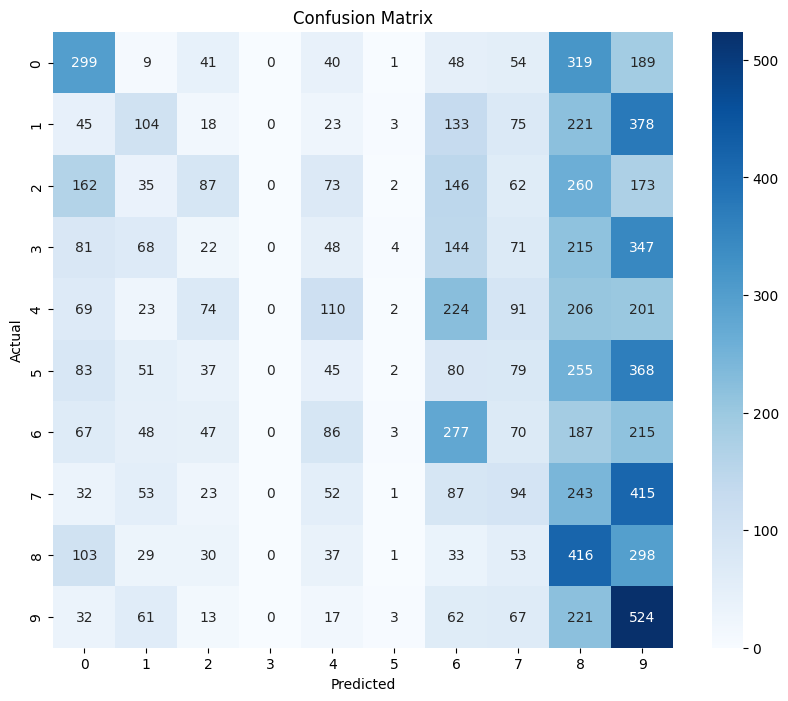

In [19]:
cm = confusion_matrix(y_test, y_pred2)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
acc2 = accuracy_score(y_test, y_pred2)
print(f"The accuracy of the model {m2} is {acc2}")

The accuracy of the model LogisticRegression(max_iter=10, multi_class='multinomial') is 0.1913


In [2]:
import pandas as pd

# Load the saved embeddings and labels from CSV
loaded_embeddings_df = pd.read_csv('embeddings.csv')
loaded_labels_df = pd.read_csv('labels.csv')

# Convert back to tensors (if necessary)
#loaded_embeddings = torch.tensor(loaded_embeddings_df.values)
#loaded_labels = torch.tensor(loaded_labels_df.values)

print(f"Loaded embeddings shape: {loaded_embeddings_df.shape}")
print(f"Loaded labels shape: {loaded_labels_df.shape}")


Loaded embeddings shape: (50000, 128)
Loaded labels shape: (50000, 1)


In [3]:
loaded_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.0,0.0,0.000000,0.0,0.758069,0.0,0.0,0.0,0.929798,0.0,...,1.986394,2.383681,0.000000,1.622467,4.054621,1.794378,5.643127,2.464263,0.727262,0.000000
1,0.0,0.0,1.519656,0.0,0.000000,0.0,0.0,0.0,1.934108,0.0,...,1.459618,0.000000,0.000000,1.434114,0.000000,2.058129,3.473111,1.794303,1.218162,0.000000
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,4.062963,0.0,...,1.088350,0.661098,0.000000,2.171391,0.000000,0.392293,4.059000,2.080294,0.000000,0.000000
3,0.0,0.0,1.013742,0.0,0.401625,0.0,0.0,0.0,0.623214,0.0,...,2.506044,0.119751,1.151258,3.669855,2.337376,2.192246,4.145818,1.897444,3.842050,0.837427
4,0.0,0.0,0.842124,0.0,1.348254,0.0,0.0,0.0,3.202197,0.0,...,1.258436,0.000000,0.000000,1.851063,0.000000,3.529149,2.141294,0.227908,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.000000,0.0,0.232753,0.0,0.0,0.0,1.466641,0.0,...,1.221254,1.916076,0.000000,1.915818,1.199264,2.380417,6.327559,2.493399,0.299499,0.000000
49996,0.0,0.0,0.838516,0.0,1.040075,0.0,0.0,0.0,1.651268,0.0,...,0.742177,0.000000,0.000000,0.781027,0.000000,2.736577,2.381755,0.210174,0.419554,0.058461
49997,0.0,0.0,0.646109,0.0,2.016676,0.0,0.0,0.0,1.532303,0.0,...,1.402136,0.647969,1.088577,0.396798,0.302779,3.188257,2.980820,1.537580,2.112488,0.785239
49998,0.0,0.0,0.362708,0.0,0.013044,0.0,0.0,0.0,2.080417,0.0,...,3.194286,0.000000,0.000000,1.685830,0.463379,4.067706,3.795564,0.897343,0.000000,0.000000
